# Solution Design
1. EDA of the Flipkart product data. 
2. Data Preprocessing: Text Cleaning, pick the textual row, concat the rows to get a single paragraph. 
3. Retrieval: Given all the products with a single text corpus, convert the text into embeddings using the deberta model. 
4. Get the vector embeddings for each product i.e. each row. 
5. Store the vector embeddings for all the product. 
6. Convert the query product into the vector embedding. 
7. Use Cosine Similarity to get the similarity between query vector and all the candidate row, (candidate rows are all the rows in database.)
8. Select the top 5 candidate with max score. 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [23]:
# Distribution of product categories
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [24]:
data = pd.read_csv("/kaggle/input/flipkart-scrapped-data-for-zepto/flipkart_com-ecommerce_sample.csv")

In [25]:
data.shape


(20002, 15)

In [26]:
# Remove the last two rows with NaN values
data = data[:20000]

In [27]:
# Check nan
data.isna().sum()

uniq_id                       0
crawl_timestamp               0
product_url                   0
product_name                  0
product_category_tree         0
pid                           0
retail_price                 78
discounted_price             78
image                         3
is_FK_Advantage_product       0
description                   2
product_rating                0
overall_rating                0
brand                      5864
product_specifications       14
dtype: int64

In [28]:
# Fill all the nan values with empty string
data = data.fillna("")

/tmp/ipykernel_34/506849531.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.fillna("")


In [29]:
data.isna().sum()

uniq_id                    0
crawl_timestamp            0
product_url                0
product_name               0
product_category_tree      0
pid                        0
retail_price               0
discounted_price           0
image                      0
is_FK_Advantage_product    0
description                0
product_rating             0
overall_rating             0
brand                      0
product_specifications     0
dtype: int64

# EDA on Product dataset

In [35]:
# General Information about the Dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   uniq_id                  20000 non-null  object
 1   crawl_timestamp          20000 non-null  object
 2   product_url              20000 non-null  object
 3   product_name             20000 non-null  object
 4   product_category_tree    20000 non-null  object
 5   pid                      20000 non-null  object
 6   retail_price             20000 non-null  object
 7   discounted_price         20000 non-null  object
 8   image                    20000 non-null  object
 9   is_FK_Advantage_product  20000 non-null  bool  
 10  description              20000 non-null  object
 11  product_rating           20000 non-null  object
 12  overall_rating           20000 non-null  object
 13  brand                    20000 non-null  object
 14  product_specifications   20000 non-nul

In [31]:
# Descriptive Statistics
data.describe()


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
count,20000,20000,20000,20000,20000,20000,20000.0,20000.0,20000,20000,20000,20000,20000,20000,20000
unique,20000,371,20000,12676,6466,19998,2248.0,2449.0,18590,2,17540,36,36,3500,18826
top,68575a4a8cedaa200f2844cfbc759986,2015-12-01 12:40:44 +0000,http://www.flipkart.com/walldesign-small-vinyl...,TheLostPuppy Back Cover for Apple iPad Air,"[""Jewellery >> Necklaces & Chains >> Necklaces""]",JEAEGE8Q8GXYFTGU,999.0,499.0,"[""http://img6a.flixcart.com/image/car-mat/m/t/...",False,TheLostPuppy Back Cover for Apple iPad Air (Mu...,No rating available,No rating available,,"{""product_specification""=>[{""key""=>""Type"", ""va..."
freq,1,1979,1,134,1567,2,1286.0,993.0,45,19215,92,18151,18151,5864,71


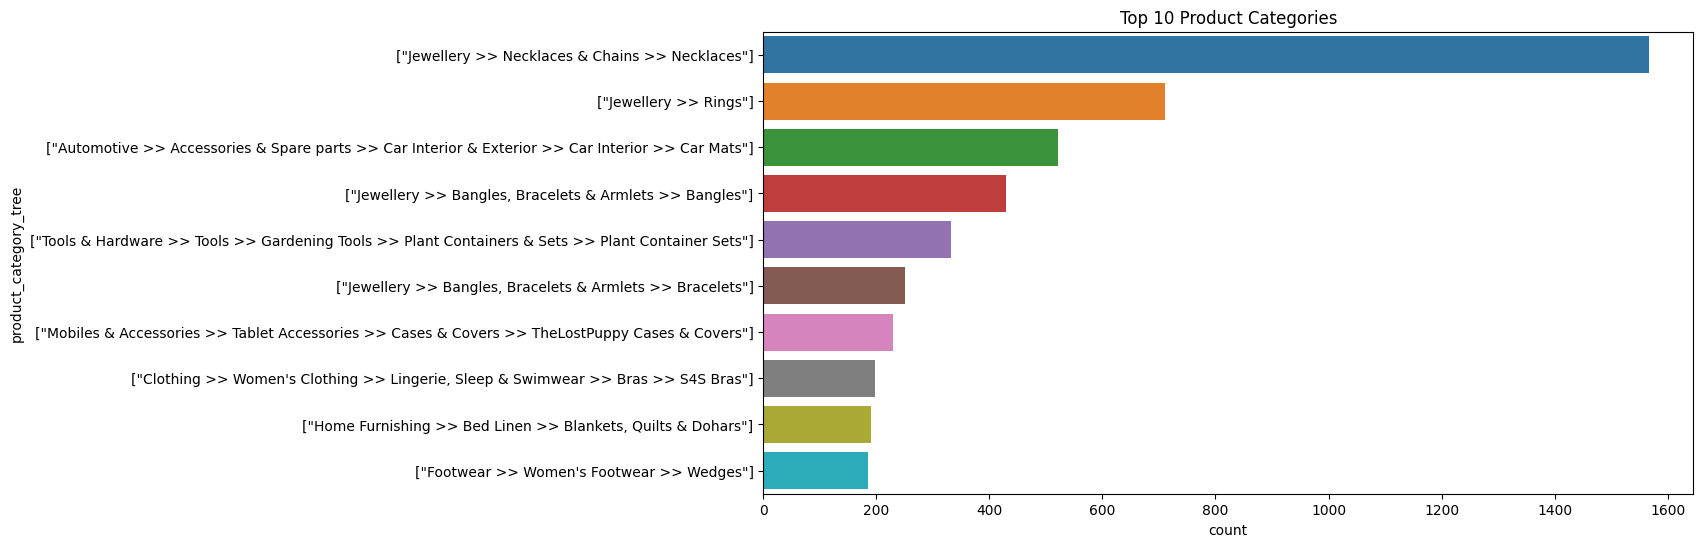

In [32]:
plt.figure(figsize=(12, 6))
sns.countplot(y='product_category_tree', data=data, order=data['product_category_tree'].value_counts().index[:10])
plt.title('Top 10 Product Categories')
plt.show()

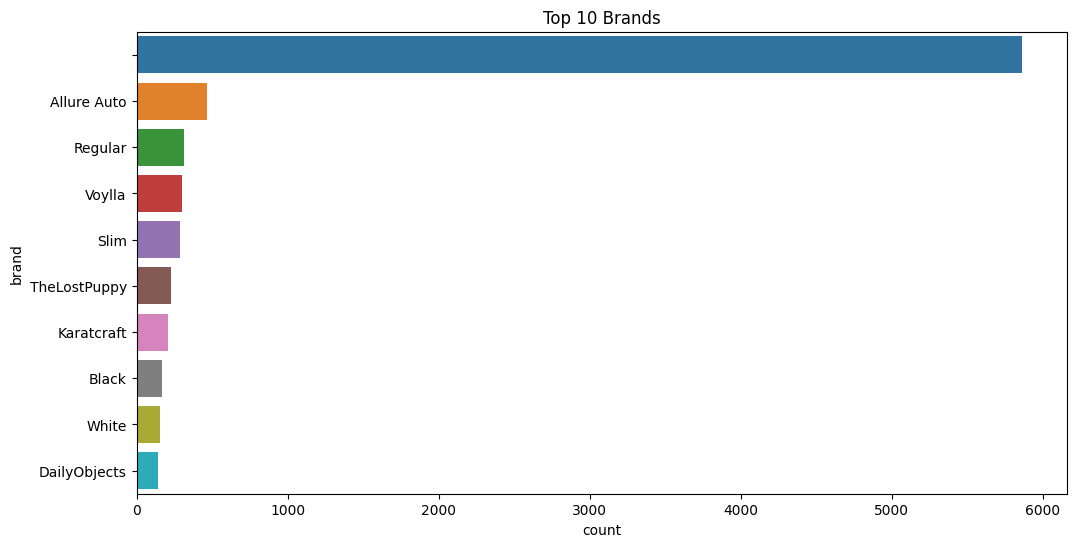

In [33]:
# Distribution of brands
plt.figure(figsize=(12, 6))
sns.countplot(y='brand', data=data, order=data['brand'].value_counts().index[:10])
plt.title('Top 10 Brands')
plt.show()

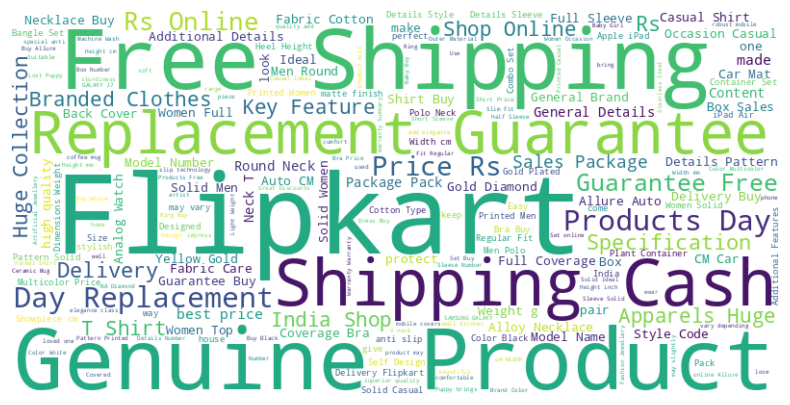

In [34]:
# Word Cloud for product descriptions
from wordcloud import WordCloud

text = " ".join(description for description in data['description'])
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Get embedding vectors for each rows

In [8]:
# Using the textual data for the getting the product information. 
data = data[['product_name','product_category_tree', 'description', 'brand', 'product_specifications']]

In [9]:

def convert_to_sentence(obj_str):
    """
    Product cateogory tree preprocessing to keep the output as comma sperated tokens.
    """
    # Remove the list brackets and double quotes
    cleaned_str = obj_str.strip('[]').replace('"', '').replace("'", "")
    
    # Split the string by " >> " to get the components
    components = cleaned_str.split(" >> ")
    
    # Join the components with commas, and "and" before the last item
    if len(components) > 1:
        sentence = ', '.join(components[:-1]) + ', and ' + components[-1]
    else:
        sentence = components[0]
    
    return sentence


In [10]:
data['product_category_tree'] = data['product_category_tree'].apply(convert_to_sentence)

In [11]:
# Merge the textual data together to get a singular sentence.
data['merged_product_info'] = data['product_name'] +' ' + data['product_category_tree'] + " "+ data['description'] + " " + data['product_specifications']

In [13]:
from transformers import AutoTokenizer, DebertaModel
import torch

# Using Deberta model for generating the vector for each row, of textual data.
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")
model = DebertaModel.from_pretrained("microsoft/deberta-base")

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
from transformers import AutoTokenizer, DebertaModel
import torch
from tqdm import tqdm

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")

# Initialize model and enable DataParallel to use multiple GPUs
model = DebertaModel.from_pretrained("microsoft/deberta-base")
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model)
model = model.to(device)  # Move the model to GPU(s)
# model.half()
def get_vector_embedding(text):
    inputs = tokenizer(text, return_tensors="pt").to(device)  # Move inputs to GPU
#     inputs.half()

    # Get the output from the model
    with torch.no_grad():
        outputs = model(**inputs)

    # The last hidden states: torch.Size([1, 294, 768])
    last_hidden_states = outputs.last_hidden_state

    # Extract the output corresponding to the [CLS] token
    cls_embedding = last_hidden_states[:, 0, :]
    
    # Explicitly delete variables and clear the GPU cache
    del inputs, outputs, last_hidden_states
    torch.cuda.empty_cache()

    return cls_embedding.cpu().numpy()

# Apply the function with a progress bar
data['merged_product_info_vector'] = None
tqdm.pandas()  # Enable tqdm progress bar for pandas
data['merged_product_info_vector'] = data['merged_product_info'].progress_apply(get_vector_embedding)

Using 2 GPUs


  0%|          | 0/10000 [00:00<?, ?it/s]2024-08-09 04:26:29.229640: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 04:26:29.229736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 04:26:29.365368: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
 59%|█████▉    | 5899/10000 [05:50<03:14, 21.04it/s]

In [ ]:
t = list(data['merged_product_info_vector'])

In [ ]:
torch.save(t, '/kaggle/working/vector-data-flipkart_20k.pt')

## Retrieve the similar products and rank them 

In [5]:
from tqdm import tqdm
import torch
import pandas as pd 
tqdm.pandas()

In [6]:
database = pd.read_csv("/kaggle/input/flipkart-scrapped-data-for-zepto/flipkart_com-ecommerce_sample.csv")

In [7]:
database['merged_product_info_vector'] = None

In [8]:
database = database[:20000]

In [10]:
# We have generated the vector database for each row in given dataset. 
# All these rows act as a candidate vectors for our query search.
database['merged_product_info_vector'] = torch.load('/kaggle/input/zepto/vector-data-flipkart_20k.pt')

In [11]:
database.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,merged_product_info_vector
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ...","[[0.054613553, -0.026611209, -0.08526676, -0.0..."
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati...","[[-0.24324645, 0.3106485, -0.14642517, -0.8335..."
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""...","[[0.054842364, -0.020803746, -0.07856124, -0.0..."
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ...","[[0.055588715, -0.024936046, -0.086399, -0.039..."
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",...","[[0.0519971, -0.022968967, -0.085648455, -0.03..."


In [12]:
text2 = "AW Bellies Footwear, Womens Footwear, Ballerinas, Key Features of AW Bellies Sandals Wedges Heel Casuals,AW Bellies Price:" 

In [13]:
from transformers import AutoTokenizer, DebertaModel
import torch

# Read the model and Tokenizer.
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")
model = DebertaModel.from_pretrained("microsoft/deberta-base")

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [14]:
from tqdm import tqdm

def get_vector_embedding(text):
    """
    Get the embedding of the given text.
    """
    inputs = tokenizer(text, return_tensors="pt")

    # Get the output from the model
    with torch.no_grad():
        outputs = model(**inputs)

    # The last hidden states: torch.Size([1, 294, 768])
    last_hidden_states = outputs.last_hidden_state

    # Extract the output corresponding to the [CLS] token
    cls_embedding = last_hidden_states[:, 0, :]
    return cls_embedding

In [15]:
# Get the embedding vector for query
vector2 = get_vector_embedding(text2)

In [16]:
from scipy.spatial.distance import cosine


def get_smilarity_score(candidate_vector,query_vector):
    "Calculate the cosine similarity for the wquery and candidate vector"
    return 1 - cosine(query_vector[0], candidate_vector[0])

In [18]:
# Get the score for each candidate vector
database['score'] = database['merged_product_info_vector'].progress_apply(get_smilarity_score,query_vector=vector2)

100%|██████████| 20000/20000 [00:01<00:00, 12312.99it/s]


In [19]:
database.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,merged_product_info_vector,score
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ...","[[0.054613553, -0.026611209, -0.08526676, -0.0...",0.999545
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati...","[[-0.24324645, 0.3106485, -0.14642517, -0.8335...",0.018075
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""...","[[0.054842364, -0.020803746, -0.07856124, -0.0...",0.999682
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ...","[[0.055588715, -0.024936046, -0.086399, -0.039...",0.999564
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",...","[[0.0519971, -0.022968967, -0.085648455, -0.03...",0.999632


In [20]:
# Sort the rows based on score 
data_sorted_score = database.sort_values(by='score', ascending=False)

In [21]:
# Select the top 5 rows which have maximum score 
data_sorted_score.head(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,merged_product_info_vector,score
18734,040c21dbda47c7e6308f3675fce08246,2016-01-04 03:25:23 +0000,http://www.flipkart.com/goldencollections-marr...,Goldencollections Marriage Jewellery Vanity Box,"[""Beauty and Personal Care >> Makeup >> Vanity...",VANEF8CF3QKU8CQN,3060.0,1699.0,"[""http://img6a.flixcart.com/image/vanity-box/c...",False,Goldencollections Marriage Jewellery Vanity Bo...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Body Mater...","[[0.07262581, -0.011484802, -0.08381909, -0.04...",0.999918
18717,92206cff28fcfa54ff685a49dccb2a39,2016-01-04 03:25:23 +0000,http://www.flipkart.com/goldencollections-beau...,Goldencollections Beautiful Stylish Jewellery ...,"[""Beauty and Personal Care >> Makeup >> Vanity...",VANEF8CFWH9NQQYT,2700.0,1499.0,"[""http://img6a.flixcart.com/image/vanity-box/q...",False,Goldencollections Beautiful Stylish Jewellery ...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Body Mater...","[[0.06885258, -0.013821308, -0.08403091, -0.04...",0.999912
3060,b71c1dd55db7c67276ac84d5bf0e1f30,2016-04-23 02:17:20 +0000,http://www.flipkart.com/klaur-melbourne-bellie...,Klaur Melbourne Bellies,"[""Klaur Melbourne Bellies""]",SHOEHXHV4SZCQB65,699.0,499.0,"[""http://img6a.flixcart.com/image/shoe/j/d/f/r...",False,Key Features of Klaur Melbourne Bellies Materi...,No rating available,No rating available,Klaur Melbourne,"{""product_specification""=>[{""key""=>""Occasion"",...","[[0.0698403, -0.003807269, -0.084347226, -0.04...",0.999906
10799,3c81f55d46b28bdd1d207821bfc0be03,2016-03-03 22:49:41 +0000,http://www.flipkart.com/rx7-superlite-hair-dry...,RX7 Superlite Hair Dryer Bonnet,"[""Health & Personal Care Appliances >> Persona...",HDNEDVWYZKSHSUXF,11410.0,11410.0,"[""http://img5a.flixcart.com/image/hair-dryer-b...",False,Specifications of RX7 Superlite Hair Dryer Bon...,No rating available,No rating available,RX7 Superlite,"{""product_specification""=>[{""key""=>""Brand"", ""v...","[[0.07016187, -0.019530084, -0.08366467, -0.04...",0.999904
9330,668c3c97a9552a0b161d03d16b5b4a95,2016-05-10 11:57:25 +0000,http://www.flipkart.com/urban-girl-foundation-...,Urban Girl Foundation Brush,"[""Urban Girl Foundation Brush (Pack of 10)""]",BAREGJ8BSB7QZ8SG,1999.0,999.0,"[""http://img6a.flixcart.com/image/brush-applic...",False,Specifications of Urban Girl Foundation Brush ...,No rating available,No rating available,Urban Girl,"{""product_specification""=>[{""key""=>""Brush Type...","[[0.05678656, -0.019087423, -0.086310126, -0.0...",0.999904


In [22]:
# TODO: 
# 1. We have used only few textual columns at the moment we can think of how we can use price, ratings and build some heuristis using all these score to have better recommendation. 
# 2. We could also use images, can get the similarity score for those as well. 
# 3. With price, rating, textual data, and images we can have a overall similarity score (wild thought)
#  Maybe we could have some annotated data, then we can have some good metrics on which we can evaluate the performance. 
#. Implement and optimize L1/L2-based similarity search for text data by vectorizing inputs and calculating distances efficiently, ensuring fast retrieval of similar text entries.